<a href="https://colab.research.google.com/github/ddchristiantan/MLZoomcamp/blob/main/MLZoomcamp_homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
df = pd.read_csv(url)


**Data preparation**

In [4]:
to_drop = ['Engine Fuel Type','Driven_Wheels','Number of Doors','Market Category','Vehicle Size','Popularity']
df.drop(columns=to_drop, inplace=True)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
df.head().T

,0,1,2,3,4
make,bmw,bmw,bmw,bmw,bmw
model,1_series_m,1_series,1_series,1_series,1_series
year,2011,2011,2011,2011,2011
engine_hp,335.0,300.0,300.0,230.0,230.0
engine_cylinders,6.0,6.0,6.0,6.0,6.0
transmission_type,manual,manual,manual,manual,manual
vehicle_style,coupe,convertible,coupe,coupe,convertible
highway_mpg,26,28,28,28,28
city_mpg,19,19,20,18,18
msrp,46135,40650,36350,29450,34500


In [6]:
df = df.fillna(0)
df.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [7]:
mean_value = df['msrp'].mean()
df['above_average'] = (df['msrp'] > mean_value).astype(int)

In [8]:
df.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
msrp                   int64
above_average          int64
dtype: object

In [9]:
df['year'] = df['year'].astype(str)

numerical_columns = ['engine_hp','engine_cylinders','highway_mpg','city_mpg']

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

**Question 1: ROC AUC feature importance**

Which numerical variable (among the following 4) has the highest AUC?
*   engine_hp
*   engine_cylinders
*   highway_mpg
*   city_mpg

In [11]:
from sklearn.metrics import roc_curve, auc

In [12]:
auc_scores = {}

to_evaluate = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for var in to_evaluate:
    fpr, tpr, thresholds = roc_curve(df_train['above_average'], df_train[var])
    auc_value = auc(fpr, tpr)
    if auc_value < 0.5:
        fpr, tpr, thresholds = roc_curve(df_train['above_average'], -df_train[var])
        auc_value = auc(fpr, tpr)
    auc_scores[var] = auc_value

highest_auc = max(auc_scores, key=auc_scores.get)

highest_auc, auc_scores


('engine_hp',
 {'engine_hp': 0.9171031265539011,
  'engine_cylinders': 0.766116490165669,
  'highway_mpg': 0.6330587871772013,
  'city_mpg': 0.6734244643245233})

**Question 2**

What's the AUC of this model on the validation dataset? (round to 3 digits)
*   0.678
*   0.779
*   0.878
*   0.979

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_val.above_average.values

df_train.drop(columns=['above_average', 'msrp'], inplace=True)
df_val.drop(columns=['above_average', 'msrp'], inplace=True)
df_test.drop(columns=['above_average', 'msrp'], inplace=True)

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(df_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [15]:
y_pred_val = model.predict_proba(X_val)[:, 1]

In [16]:
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_pred_val)

auc_value_val = auc(fpr_val, tpr_val)

round(auc_value_val, 3)

0.982

**Question 3**

At which precision and recall curves intersect?
*   0.28
*   0.48
*   0.68
*   0.88



In [17]:
from sklearn.metrics import accuracy_score

In [18]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred_val >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.804
0.10 0.853
0.15 0.884
0.20 0.903
0.25 0.917
0.30 0.925
0.35 0.933
0.40 0.940
0.45 0.942
0.50 0.943
0.55 0.939
0.60 0.940
0.65 0.934
0.70 0.932
0.75 0.927
0.80 0.916
0.85 0.889
0.90 0.880
0.95 0.846
1.00 0.726


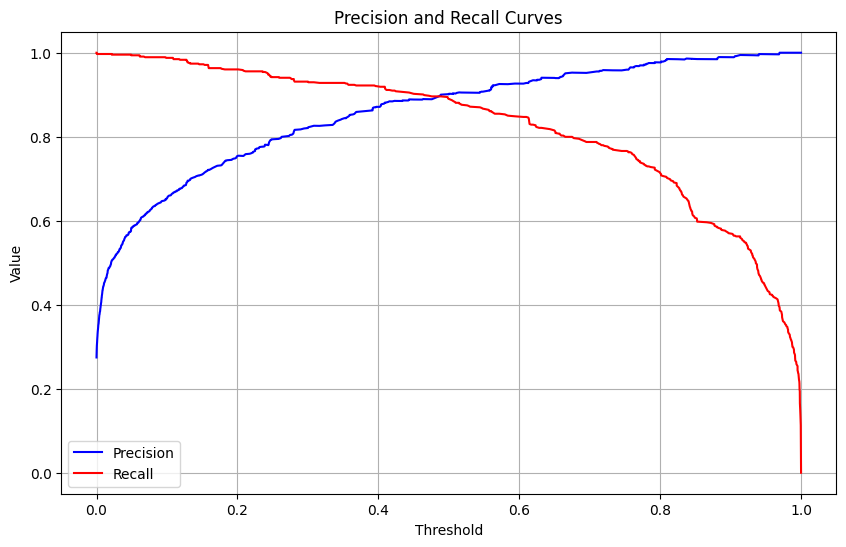

In [19]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_val)
thresholds_pr = np.append(thresholds_pr, 1)


plt.figure(figsize=(10, 6))
plt.plot(thresholds_pr, precision, label='Precision', color='blue')
plt.plot(thresholds_pr, recall, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall Curves')
plt.legend()
plt.grid(True)
plt.show()



In [20]:
intersection_threshold = thresholds_pr[np.argmin(np.abs(precision - recall))]

intersection_threshold

0.48582295382594803

**Question 4**

At which threshold F1 is maximal?
*   0.12
*   0.32
*   0.52
*   0.72

In [21]:
thresholds = np.arange(0, 1.01, 0.01)


In [25]:
from sklearn.metrics import precision_score, recall_score

f1_scores = []
for t in thresholds:
    predictions = (y_pred_val >= t).astype(int)
    P = precision_score(y_val, predictions, zero_division=1)
    R = recall_score(y_val, predictions)

    if P + R != 0:  # Avoid division by zero
        f1 = 2 * P * R / (P + R)
    else:
        f1 = 0.0

    f1_scores.append(f1)


In [26]:
optimal_threshold = thresholds[np.argmax(f1_scores)]
optimal_threshold

0.49

**Question 5**

How large is standard devidation of the scores across different folds?
*   0.003
*   0.030
*   0.090
*   0.140


In [42]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Lists to store AUC scores for each fold
auc_scores = []

# Iterate over different folds
for train_idx, val_idx in kfold.split(df_full_train):
    # Split the data into train and validation
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = df_train_fold.above_average.values
    y_val_fold = df_val_fold.above_average.values

    # Apply one-hot-encoding using DictVectorizer
    X_train_fold = dv.transform(df_train_fold.to_dict(orient='records'))
    X_val_fold = dv.transform(df_val_fold.to_dict(orient='records'))

    # Train the logistic regression model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold and compute AUC
    y_pred_val_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)
    auc_scores.append(auc_val_fold)

# Compute standard deviation of the AUC scores across different folds
std_dev_auc = np.std(auc_scores)

std_dev_auc


0.0023180009930647764

Question 6

Which C leads to the best mean score?
*   0.01
*   0.1
*   0.5
*   10


In [47]:
dv = DictVectorizer(sparse=False)
full_train_dict = df_full_train.drop(columns=['above_average']).to_dict(orient='records')
dv.fit(full_train_dict)

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Define the C values for hyperparameter tuning
C_values = [0.01, 0.1, 0.5, 10]

# Perform 5-fold CV for each C value
mean_scores = {}
std_scores = {}

for C in C_values:
    auc_scores_c = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = df_train_fold.above_average.values
        y_val_fold = df_val_fold.above_average.values

        X_train_fold = dv.transform(df_train_fold.to_dict(orient='records'))
        X_val_fold = dv.transform(df_val_fold.to_dict(orient='records'))

        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold, y_train_fold)

        y_pred_val_fold = model_fold.predict_proba(X_val_fold)[:, 1]
        auc_val_fold = roc_auc_score(y_val_fold, y_pred_val_fold)
        auc_scores_c.append(auc_val_fold)

    mean_scores[C] = round(np.mean(auc_scores_c), 3)
    std_scores[C] = round(np.std(auc_scores_c), 3)

best_C = max(mean_scores, key=mean_scores.get)

best_C, mean_scores, std_scores

(0.5,
 {0.01: 0.983, 0.1: 0.983, 0.5: 0.985, 10: 0.983},
 {0.01: 0.006, 0.1: 0.006, 0.5: 0.006, 10: 0.006})